In [1]:
using Gen
using StatsPlots

In [2]:
@gen function sleep_model()
    feeling_lazy ~ bernoulli(0.9)
    ignore_alarm ~ bernoulli(0.8 * feeling_lazy)
    amount_slept_mu = 6 + 2 * feeling_lazy + 2 * ignore_alarm
    amount_slept ~ normal(amount_slept_mu, 1)
    return amount_slept
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##sleep_model#274", Bool[], false)

We can simply sample from the model (forward)

In [3]:
@time model_samples = [sleep_model() for _ in 1:100_000];

  0.042420 seconds (301.94 k allocations: 9.150 MiB, 92.69% compilation time)


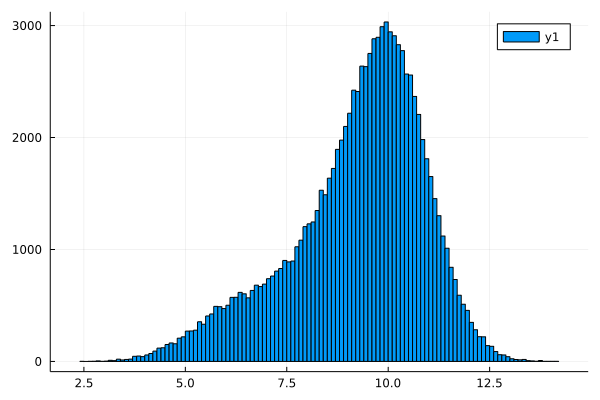

In [4]:
plot(model_samples, seriestype=:histogram)

We can also get the 'weight':

Given arguments $x$ (args) and assignment $u$ (constraints) (which is empty for the first form), sample $t \sim q(\cdot; u, x)$ and $r \sim q(\cdot; x, t)$, and return the trace $(x, t, r)$ (trace). Also return the weight (weight):

weight $= \log \frac{p(t, r; x)}{q(t; u, x) q(r; x, t)}$

In [5]:
trace,logweight = Gen.generate(sleep_model, # model as function i.e. () omitted at the end
                                () # these are the arguments, in our case empty
                                )
weight = exp(logweight)
@info "Weights:" logweight weight
Gen.get_choices(trace)

┌ Info: Weights:
│   logweight = 0.0
│   weight = 1.0
└ @ Main In[5]:5


│
├── :feeling_lazy : true
│
├── :amount_slept : 9.26839890798199
│
└── :ignore_alarm : true


In [6]:
trace,logweight = Gen.generate(sleep_model, # model as function i.e. () omitted at the end
                             (), # these are the arguments, in our case empty
                             Gen.choicemap((:feeling_lazy, false)) # the constraints
                                )
weight = exp(logweight)
@info "Weights:" logweight weight
Gen.get_choices(trace)

┌ Info: Weights:
│   logweight = -2.302585092994046
│   weight = 0.09999999999999998
└ @ Main In[6]:6


│
├── :feeling_lazy : false
│
├── :amount_slept : 6.924967984437564
│
└── :ignore_alarm : false


## I don't really understand what the weight is and how it is needed.

To get a marginal likelihood we have to use importance sampling:

In [7]:
trace, logprob = Gen.importance_resampling(sleep_model, (), Gen.EmptyChoiceMap(), 100_000)

prob = exp(logprob)
@info "Probabilities:" logprob prob
Gen.get_choices(trace)

┌ Info: Probabilities:
│   logprob = 8.348877145181177e-14
│   prob = 1.0000000000000835
└ @ Main In[7]:4


│
├── :feeling_lazy : true
│
├── :amount_slept : 9.55462734647545
│
└── :ignore_alarm : true


In [8]:
traces, logweights, logprob = Gen.importance_sampling(sleep_model, (), Gen.EmptyChoiceMap(), 100_000)

weights = exp.(logweights)
#@info "Weights:" logweights weights
prob = exp(logprob)
@info "Probabilities:" logprob prob
Gen.get_choices(trace)

┌ Info: Probabilities:
│   logprob = 0.0
│   prob = 1.0
└ @ Main In[8]:6


│
├── :feeling_lazy : true
│
├── :amount_slept : 9.55462734647545
│
└── :ignore_alarm : true


# Given that I only slept 6 hours, how likely is it that I was lazy?

In [9]:
trace, logprob = Gen.importance_resampling(sleep_model, (), Gen.choicemap((:amount_slept, 6.0)), 100_000)

# This is the most likely trace given our constraints
Gen.get_choices(trace)

│
├── :feeling_lazy : true
│
├── :amount_slept : 6.0
│
└── :ignore_alarm : false


In [10]:
trace,logweight = Gen.generate(sleep_model, # model as function i.e. () omitted at the end
                             (), # these are the arguments, in our case empty
                             Gen.choicemap((:amount_slept, 6.0)) # the constraints
                                )
weight = exp(logweight)
@info "Weights:" logweight weight
Gen.get_choices(trace)

┌ Info: Weights:
│   logweight = -8.918938533204672
│   weight = 0.00013383022576488542
└ @ Main In[10]:6


│
├── :feeling_lazy : true
│
├── :amount_slept : 6.0
│
└── :ignore_alarm : true


Are we only able to count number of occurances in samples?